In [51]:
#!/usr/bin/env python
# coding: utf-8

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lower, when, to_timestamp, date_format,
    sum as spark_sum, coalesce, lit
)
from functools import reduce
spark = SparkSession.builder.appName("MonthlySentimentScoresCombined").getOrCreate()

#Read CSV
input_path = "file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv"

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(input_path)
)

#Filter English tweets and non-null text
df = df.filter((col("tweet_language") == "en") & (col("text").isNotNull()))

#Fill nulls in numeric columns
df = (
    df.withColumn("n_replies", coalesce(col("n_replies").cast("double"), lit(0.0)))
      .withColumn("n_likes", coalesce(col("n_likes").cast("double"), lit(0.0)))
      .withColumn("n_retweets", coalesce(col("n_retweets").cast("double"), lit(0.0)))
)

#Define roots, phrases, emojis
def roots_to_regex(roots):
    return [rf"\b{root}\w*\b" for root in roots]

positive_roots = ["bull", "moon", "pump", "gain", "profit", "good", "great"]
positive_phrases = ["to the moon", "all time high", "buy the dip"]
positive_emojis = ["😀", "🚀", "💰"]

negative_roots = ["bear", "dump", "crash", "loss", "bad", "terribl"]
negative_phrases = ["all my money is gone", "bear market"]
negative_emojis = ["😡", "📉", "😭"]

#Build detection conditions
text_lower = lower(col("text"))

pos_conditions = (
    [text_lower.rlike(regex) for regex in roots_to_regex([r.lower() for r in positive_roots])] +
    [text_lower.contains(phrase.lower()) for phrase in positive_phrases] +
    [col("text").contains(e) for e in positive_emojis]
)

neg_conditions = (
    [text_lower.rlike(regex) for regex in roots_to_regex([r.lower() for r in negative_roots])] +
    [text_lower.contains(phrase.lower()) for phrase in negative_phrases] +
    [col("text").contains(e) for e in negative_emojis]
)

pos_cond = reduce(lambda a, b: a | b, pos_conditions) if pos_conditions else lit(False)
neg_cond = reduce(lambda a, b: a | b, neg_conditions) if neg_conditions else lit(False)

#Add month, weights, and tweet-level scores
df = df.withColumn("timestamp", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ssXXX"))
df = df.withColumn("month", date_format(col("timestamp"), "yyyy-MM"))

#Base weight = sum of engagement metrics normalized + small constant
df = df.withColumn("base_weight", (col("n_replies") + col("n_likes") + col("n_retweets")) / 100.0 + lit(0.1))

#Detect positive and negative
df = df.withColumn("is_positive", pos_cond)
df = df.withColumn("is_negative", neg_cond)

#Assign sentiment label
df = df.withColumn(
    "sentiment",
    when(col("is_positive") & ~col("is_negative"), lit("positive"))
    .when(col("is_negative") & ~col("is_positive"), lit("negative"))
    .otherwise(lit("neutral"))
)

#Assign numeric scores
df = df.withColumn(
    "positive_score",
    when(col("sentiment") == "positive", col("base_weight")).otherwise(lit(0.0))
)
df = df.withColumn(
    "negative_score",
    when(col("sentiment") == "negative", col("base_weight")).otherwise(lit(0.0))
)
df = df.withColumn(
    "neutral_score",
    when(col("sentiment") == "neutral", col("base_weight")).otherwise(lit(0.0))
)

#Aggregate monthly sentiment
monthly_sentiment = (
    df.groupBy("month")
      .agg(
          spark_sum("positive_score").alias("positive_score"),
          spark_sum(when(col("sentiment")=="positive", lit(1)).otherwise(lit(0))).alias("positive_tweet_count"),
          
          spark_sum("negative_score").alias("negative_score"),
          spark_sum(when(col("sentiment")=="negative", lit(1)).otherwise(lit(0))).alias("negative_tweet_count"),
          
          spark_sum("neutral_score").alias("neutral_score"),
          spark_sum(when(col("sentiment")=="neutral", lit(1)).otherwise(lit(0))).alias("neutral_tweet_count")
      )
      .orderBy("month")
)

monthly_sentiment.show(20, truncate=False)


#Save results to CSV
output_path = "file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/monthly_sentiment_scores.csv"

monthly_sentiment.coalesce(1).write.mode("overwrite").option("header", True).csv(output_path)


25/12/07 17:01:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-------+------------------+--------------------+------------------+--------------------+-------------------+-------------------+
|month  |positive_score    |positive_tweet_count|negative_score    |negative_tweet_count|neutral_score      |neutral_tweet_count|
+-------+------------------+--------------------+------------------+--------------------+-------------------+-------------------+
|2018-09|0.0               |0                   |0.0               |0                   |0.15000000000000002|1                  |
|2018-12|0.0               |0                   |0.0               |0                   |0.96               |1                  |
|2019-03|0.9199999999999999|4                   |0.0               |0                   |0.0                |0                  |
|2019-05|24.790000000000035|58                  |7.7399999999999975|9                   |480.06000000000176 |230                |
+-------+------------------+--------------------+------------------+--------------------+-

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Convert sentiment labels to numeric
# 'sentiment' column already exists with values: 'positive', 'negative', 'neutral'
indexer = StringIndexer(inputCol="sentiment", outputCol="label")  # labelCol required for classifier

# -------------------------------
# 2. Text processing pipeline
# -------------------------------
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# -------------------------------
# 3. Classifier
# -------------------------------
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, family="multinomial")

# -------------------------------
# 4. Build pipeline
# -------------------------------
pipeline = Pipeline(stages=[indexer, tokenizer, remover, hashingTF, idf, lr])

# -------------------------------
# 5. Split data
# -------------------------------
train, test = df.randomSplit([0.8, 0.2], seed=1234)

# -------------------------------
# 6. Train model
# -------------------------------
model = pipeline.fit(train)

# -------------------------------
# 7. Make predictions
# -------------------------------
preds = model.transform(test)

# -------------------------------
# 8. Evaluate accuracy
# -------------------------------
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# -------------------------------
# Optional: Show predictions
# -------------------------------
preds.select("text", "sentiment", "prediction").show(10, truncate=100)

25/12/07 16:52:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv
25/12/07 16:52:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv
25/12/07 16:52:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, 

Test Accuracy: 90.14%
+----------------------------------------------------------------------------------------------------+---------+----------+
|                                                                                                text|sentiment|prediction|
+----------------------------------------------------------------------------------------------------+---------+----------+
|The first lab made diamond happened in 1955 &amp; now they are so flawless that mined diamonds ca...|  neutral|       0.0|
|#Bitcoin #Satoshi #crypto #blockchain #Airdrop New Airdrop #Idap 📢  Idap Round 3 airdrop is wort...| positive|       1.0|
|1/2 well I want to do another #giveaway (as that amount is still sitting with me) but I know peop...|  neutral|       0.0|
|We will be releasing more information about our games and token sale soon.  #AioCasino #AioToken ...|  neutral|       0.0|
|BTC IS STILL GOING STRONG!!  Thus, we are giving away 0.04 BTC and 10 BNB to 2 lucky winners!  GI...|  neutral

25/12/07 16:52:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv


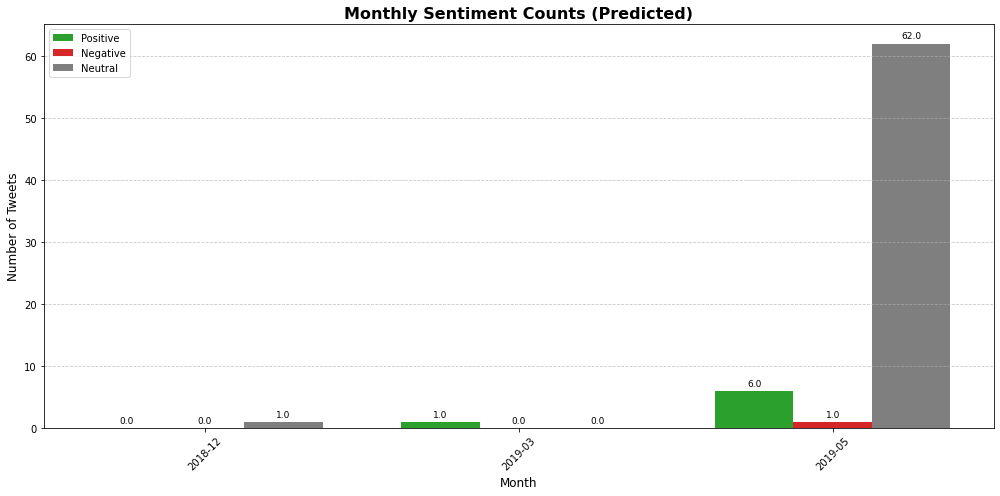

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example: monthly_pivot = DataFrame with columns 'positive', 'negative', 'neutral', index = months
months = monthly_pivot.index.tolist()
positive = monthly_pivot['positive'].tolist()
negative = monthly_pivot['negative'].tolist()
neutral = monthly_pivot['neutral'].tolist()

x = np.arange(len(months))  # positions for months
width = 0.25  # width of each bar

plt.figure(figsize=(14,7))

# Plot grouped bars
plt.bar(x - width, positive, width=width, label='Positive', color='#2ca02c')
plt.bar(x, negative, width=width, label='Negative', color='#d62728')
plt.bar(x + width, neutral, width=width, label='Neutral', color='#7f7f7f')

# Add data labels
for i in range(len(months)):
    plt.text(x[i] - width, positive[i] + 0.5, str(positive[i]), ha='center', va='bottom', fontsize=9)
    plt.text(x[i], negative[i] + 0.5, str(negative[i]), ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width, neutral[i] + 0.5, str(neutral[i]), ha='center', va='bottom', fontsize=9)

# Customize
plt.title("Monthly Sentiment Counts (Predicted)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(x, months, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

25/12/07 16:58:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv
25/12/07 16:58:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv


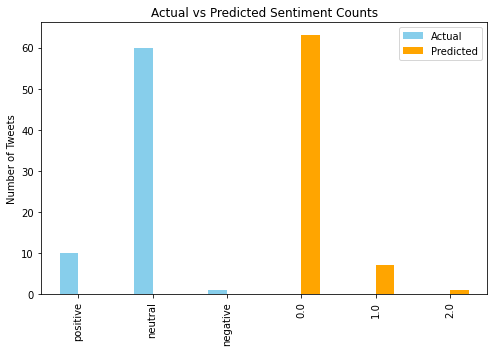

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

actual_counts = preds.groupBy("sentiment").count().toPandas().set_index("sentiment")
pred_counts = preds.groupBy("prediction").count().toPandas().set_index("prediction")

df_plot = pd.concat([actual_counts, pred_counts], axis=1)
df_plot.columns = ["Actual", "Predicted"]
df_plot.plot(kind="bar", figsize=(8,5), color=["skyblue", "orange"])
plt.ylabel("Number of Tweets")
plt.title("Actual vs Predicted Sentiment Counts")
plt.show()


In [50]:
spark.stop()